In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [17]:
torch.manual_seed(1)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64 #batch size originally 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [19]:
# # functions to show an image

# def imshow(img):
#     print(img.size)
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # get some random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # show images
# #imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [20]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels= 64, kernel_size =7, padding=3)#in channels, out channels, kernel size #PADDING IS ON EACH SIDE!!!
        self.conv2 = nn.Conv2d(in_channels=64,out_channels= 128, kernel_size =3, padding=1)
        self.conv31 = nn.Conv2d(in_channels=128,out_channels= 256, kernel_size =3, padding=1)
        self.conv32 = nn.Conv2d(in_channels=256,out_channels= 256, kernel_size =3, padding=1)#output 4x4x256 = 4096

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4 * 4 * 256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print("size after CNN1: ", x.size())
        x = self.pool(F.relu(self.conv2(x)))
        #print("size after CNN2: ", x.size())
        x = self.pool(F.relu(self.conv32(F.relu(self.conv31(x)))))
        #print("size after CNN3: ", x.size())
        x = torch.flatten(x, start_dim=1) # flatten all dimensions except batch
        x = self.fc1(x)
        #x = nn.Softmax(x, dim = 1)#NOT CALLING THIS BECAUSE CROSSENTROPYLOSS BELOW ALREADY INCLUDES SOFTMAX, also reduces accuracy
        return x

In [21]:
#initialize
#net = Net()
net = myNet()
net.to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001, amsgrad=True)

In [22]:
#train, outputting loss after each batch in each epoch
losses = []
trainErrors = []
testErrors = []
times = []
cumetime = []
totaltime = 0
for epoch in range(30):  # loop over the dataset multiple times
    epoch_begin = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        #print(inputs.size())
        #print(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0
    totaltime+=time.time() - epoch_begin
    cumetime.append(totaltime)
    times.append(time.time() - epoch_begin)

    losses.append(running_loss)
    
    #measure training error at end of each epoch, followed by testing error
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in trainloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    trainErrors.append(100 * (total-correct)//total)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    testErrors.append(100 * (total-correct)//total)

print('Finished Training')

Finished Training


In [23]:
print(100-testErrors[9])

74


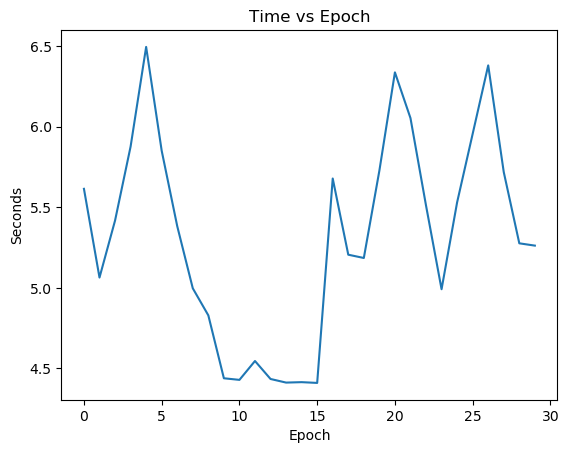

In [24]:
#generate graphs
plt.plot(times)
plt.title("Time vs Epoch")
plt.xlabel('Epoch') 
plt.ylabel('Seconds') 
plt.show()

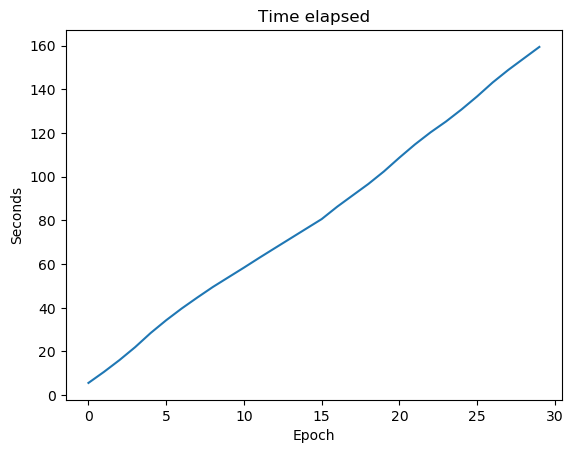

In [25]:
plt.plot(cumetime)
plt.title("Time elapsed")
plt.xlabel('Epoch') 
plt.ylabel('Seconds') 
plt.show()

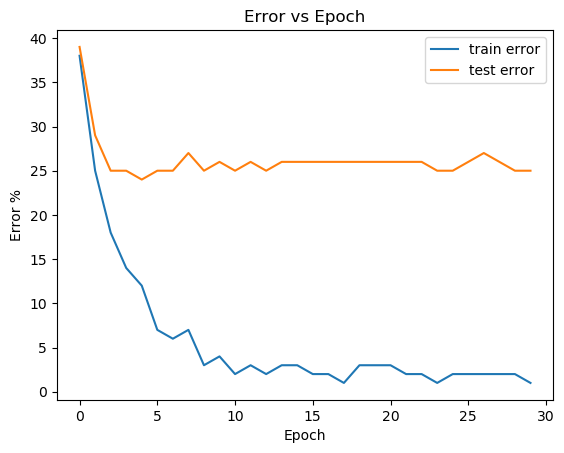

In [26]:
plt.plot(trainErrors, label = "train error")
plt.plot(testErrors, label = "test error")
plt.title("Error vs Epoch")
plt.xlabel('Epoch') 
plt.ylabel('Error %') 
plt.legend()
plt.show()

IGNORE THE FOLLOWING BLOCKS USED DURING 

In [27]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 74 %


In [28]:
# #save the state of trained model to path
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

In [29]:
#test trained model network against test data
dataiter = iter(testloader)
images, labels = next(dataiter)[0].to(device), next(dataiter)[1].to(device)
#print(images.size())
# print images
#imshow(torchvision.utils.make_grid(images))
#print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [30]:
#comparing
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck frog  dog   horse ship  frog  horse bird  deer  truck deer  deer  bird  plane truck frog  frog  dog   bird  dog   truck ship  deer  car   truck dog   deer  frog  horse frog  plane truck cat   ship  horse bird  truck ship  bird  cat   ship  ship  deer  dog   deer  frog  horse dog   frog  cat  


In [31]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 74 %
